In [1]:
'''
Q1.3 
'''
import gym
import numpy as np

maxIter = 100

def testPolicy(env, policy, n, verbose=False):
    """
    @params policy: a deterministic policy that maps a state in R^{n} -> a
    @params n: number of iterations to evaluate the policy.
    """
    env.reset()
    results = np.zeros(n)
    
    for i in range(n):
        if verbose: 
            print("Starting episode : %s" % i)
        observation = env.reset()
        for _ in range(maxIter):
            a = policy[observation]
            observation, reward, done, info = env.step(a)
            if verbose:
                env.render()
                print("The observation is: %s; Reward is: %s; Done: %s" % (observation, reward, done))
            if done:
                if reward == 1:
                    results[i] = 1
                else:
                    results[i] = 0 
                break
    return np.sum(results) / n

env = gym.make("FrozenLake-v0")
n = 100
policy = np.mod(np.arange(0, 16) + 1, 4)
success_rate = testPolicy(env, policy, n, verbose=True)
env.close()
print("The success rate is: %s over %s trials." % (success_rate, n))

Starting episode : 0
  (Down)
SFFF
FHFH
FFFH
HFFG
The observation is: 1; Reward is: 0.0; Done: False
  (Right)
SFFF
FHFH
FFFH
HFFG
The observation is: 5; Reward is: 0.0; Done: True
Starting episode : 1
  (Down)
SFFF
FHFH
FFFH
HFFG
The observation is: 4; Reward is: 0.0; Done: False
  (Down)
SFFF
FHFH
FFFH
HFFG
The observation is: 4; Reward is: 0.0; Done: False
  (Down)
SFFF
FHFH
FFFH
HFFG
The observation is: 5; Reward is: 0.0; Done: True
Starting episode : 2
  (Down)
SFFF
FHFH
FFFH
HFFG
The observation is: 4; Reward is: 0.0; Done: False
  (Down)
SFFF
FHFH
FFFH
HFFG
The observation is: 4; Reward is: 0.0; Done: False
  (Down)
SFFF
FHFH
FFFH
HFFG
The observation is: 5; Reward is: 0.0; Done: True
Starting episode : 3
  (Down)
SFFF
FHFH
FFFH
HFFG
The observation is: 0; Reward is: 0.0; Done: False
  (Down)
SFFF
FHFH
FFFH
HFFG
The observation is: 4; Reward is: 0.0; Done: False
  (Down)
SFFF
FHFH
FFFH
HFFG
The observation is: 5; Reward is: 0.0; Done: True
Starting episode : 4
  (Down)
SFFF
FHFH

In [2]:
'''
Q1.4
'''
def learnModel(env, n, maxIter, n_state, n_action):
    """
    Learn the transition model and reward for a particular environment.
    :param env: the environment;
    :param n: Total number of samples
    :param maxIter: the maximum number of iterations in each episode
    :param n_state: The total number of states
    :param n_action: The total number of actions
    """
    R = np.zeros((n_state, n_action, n_state))
    C = np.zeros((n_state, n_action, n_state)) # counts for (s,a,s')
    c = 0
    while c < n:
        s = env.reset()
        for _ in range(maxIter):
            a = env.action_space.sample()
            s_n, r, done, info = env.step(a)
            c += 1
            R[s, a, s_n] += r
            C[s, a, s_n] += 1
            s = s_n
            
            # env.render()
            # print("The observation is: %s; Reward is: %s; Done: %s" % (observation, reward, done))
            if done:
                break
    
    P = np.zeros((n_state, n_action, n_state))
    
    # Convert counts to probability;
    for i in range(n_state):
        for j in range(n_action):
            total_c =  np.sum(C[i,j,:])
            if total_c != 0:
                P[i,j,:] = C[i,j,:] / np.sum(C[i,j,:])
            for k in range(n_state):
                if C[i,j, k] != 0:
                    R[i,j,k] = R[i,j,k] / C[i,j,k]
    return P, R

def learn_model_frozen_lake(env):
    n_state = 16
    n_action = 4
    maxIter = 100
    n = 10 ** 5
    P, R = learnModel(env, n, maxIter, n_state, n_action)
    return P, R

def test_learn_model_frozen_lake():
    env = gym.make("FrozenLake-v0")
    P, R = learn_model_frozen_lake(env)
    env.close()
    actual_reward = np.array([R[14, 2, 15], R[0, 2, 1], R[0, 2, 15]])
    expected_reward = np.array([1.0,0., 0.])
    expected_prob = np.array([0., 0., 0., 0.,1/3, 0., 0., 0., 0., 1/3, 0., 0., 1/3, 0., 0., 0.]) # probablity for (3,1) -> 1/3 for states corresponding to Up, down, and Right
    actual_prob = P[8, 2, :]
    assert np.isclose(expected_reward, actual_reward).all(), "The expected and actual reward do not match." \
     + "Expected: %s; Actual: %s" % (expected_reward, actual_reward)
    assert np.isclose(expected_prob, actual_prob, atol = 0.05).all(), "The expected and actual probabilites for (3,1) x Right do not match." \
     + "Expected: %s; Actual: %s" % (expected_prob, actual_prob)
    print("Tests for Frozen Lake reward passed.")
    
test_learn_model_frozen_lake()

Tests for Frozen Lake reward passed.


In [3]:
import matplotlib.pyplot as plt

action_mapping = {
  -1: "N/A",
  0: "L",
  1: "D",
  2: "R",
  3: "U"
}

"""
Helper function for plotting Policy and Value.
"""

def plot_optimal_value_and_control(V, pi, t, algo, gamma, fname=None, savefig=False):
  fig = plt.figure(figsize=(10, 10))

  ax1 = plt.subplot(1, 2, 1)
  ax1.set_title("Optimal values for time at: %s" % t)
  ax1.imshow(V, cmap='gray')
  ax1.axis('off')

  ax2 = plt.subplot(1, 2, 2)
  ax2.set_title("Optimal actions for time at: %s" % t)
  ax2.imshow(pi, cmap='hot')
  ax2.axis('off')

  for i in range(V.shape[0]):
    for j in range(V.shape[1]):
       ax1.text(j, i, '%.4f' % V[i, j], ha="center", va="center", color="b")
       ax2.text(j, i, action_mapping[pi[i, j]], ha="center", va="center", color="b")

  plt.tight_layout()
  if savefig:
     plt.savefig('./fig/' + fname + ".png")
  plt.show()

def plot_success(success, algo, fname=None, savefig=False):
  fig = plt.figure(figsize=(10, 10))
  ax = plt.subplot(1, 1, 1) 
  ax.set_title("Success rate for algorithm: %s" % algo)
  ax.plot(success)
  if savefig:
    plt.savefig('./fig/' + fname + ".png")
  plt.show()



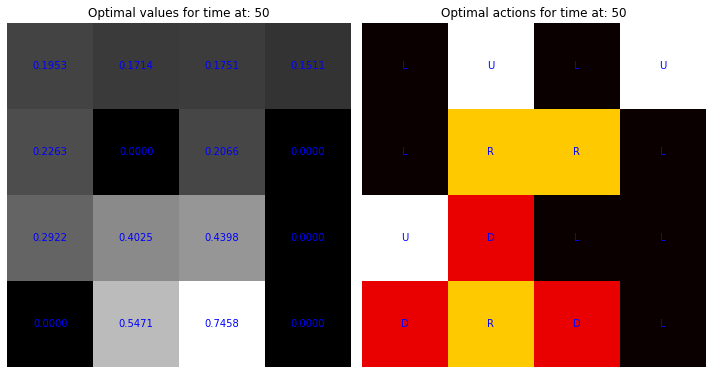

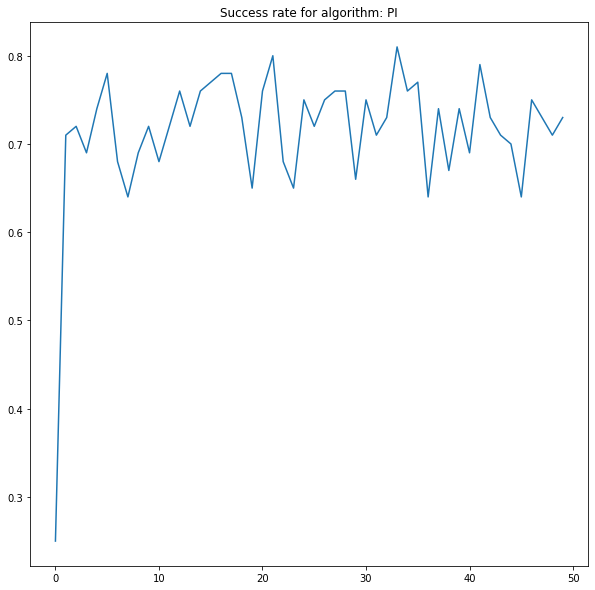

In [4]:

'''
Q1.5 Policy Evaluation, Improvement and Policy Iteration.
'''
def policy_eval(pi, V_init, P, R, gamma, maxIter, t):
    '''
    Perform Policy evaluation on a given policy;
    :param pi: the policy to evaluate;
    :param V: the previous value functions;
    :param P: the transition probabilities;
    :param R: the reward functions;
    :param gamma: the discount factor;
    :param maxIter: the maximum number of iterations to perform;
    :param t: the threshold of exiting policy evaluation.
    '''
    V = np.copy(V_init)
    V_next = np.zeros(V.shape)
    delta = np.full(V.shape, np.inf)
    i = 0
    while i < maxIter and np.amax(np.absolute(delta)) > t:
        for j in range(V.shape[0]):
            a = pi[j]
            p = P[j, a, :]
            ind = np.nonzero(p)
            r = R[j, a, ind]
            V_tmp = r + gamma * V[ind]
            V_next[j] = np.dot(p[ind], V_tmp.flatten())
        delta = V_next - V
        i = i + 1
        V = np.copy(V_next)
    return V, np.amax(np.absolute(delta))
        
def policy_improvement(pi_init, V, A, P, R, gamma, maxIter):
    '''
    Perform policy improvement on the policy \pi.
    :param pi_init: the policy to improve;
    :param V: the value function;
    :param A: the action space;
    :param P: the transition probabilities;
    :param R: the reward functions;
    :param gamma: the discount factor;
    :param maxIter: the maximum number of iterations to perform;
    '''
    converged = False
    i = 0
    pi = np.copy(pi_init)
    pi_next = np.copy(pi)
    while i < maxIter and not converged:
        for s in range(pi.shape[0]):
            q_max = 0
            a_max = pi[s]
            for a in range(A.shape[0]):
                p = P[s, a, :]
                ind = np.nonzero(p)
                r = R[s, a, ind]
                q = np.dot(p[ind], (r + gamma * V[ind]).flatten())
                if q > q_max:
                    q_max = q
                    a_max = a
            pi_next[s] = a_max
        converged = np.array_equal(pi, pi_next)
        pi = np.copy(pi_next)
        i += 1
    return pi

def policy_iteration(env, S, A, P, R, gamma, maxIter, t, n):
    '''
    :param env: the environment
    :param S: the state space; 
    :param A: the action space;
    :param P: the transition probabilities;
    :param R: the reward functions;
    :param gamma: the discount factor;
    :param maxIter: the maximum number of iterations to perform;
    :param t: the threshold of exiting policy evaluation.
    :param n: number of times to perform policy eval and improvement;
    '''
    V = np.zeros(S.shape)
    pi = np.mod(np.arange(0, 16) + 1, 4)
    m = np.zeros(n)
    for i in range(n):
        V, l = policy_eval(pi, V, P, R, gamma, maxIter, t)
        pi = policy_improvement(pi, V, A, P, R, gamma, maxIter)
        success_rate = testPolicy(env, pi, 100)
        m[i] = success_rate
    return m, pi, V
        
def policy_iteration_main():
    gamma = 0.95
    n = 50
    maxIter = 20
    t = 1e-6
    S = np.arange(0, 16)
    A = np.arange(0, 4)
    env = gym.make("FrozenLake-v0", is_slippery=True)
    P, R = learn_model_frozen_lake(env)
    m, pi, V = policy_iteration(env, S, A, P, R, gamma, maxIter, t, n)
    plot_optimal_value_and_control(V.reshape(4,4,order='C'), pi.reshape(4,4,order='C'),\
                                   n, "Policy Iteration", gamma, 'P1_PI_Value', True)
    env.close()
    plot_success(m, "PI", 'P1_PI_success', True)

policy_iteration_main()

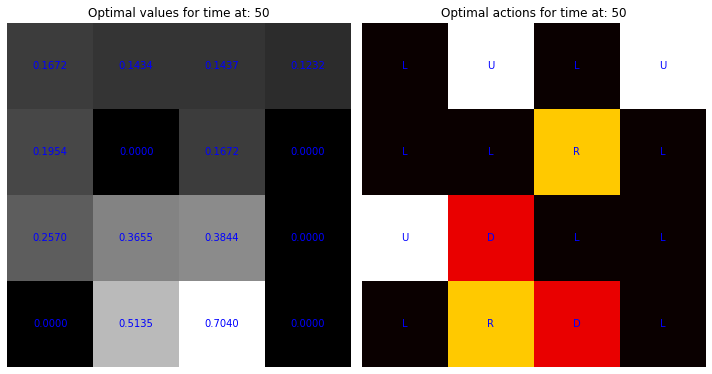

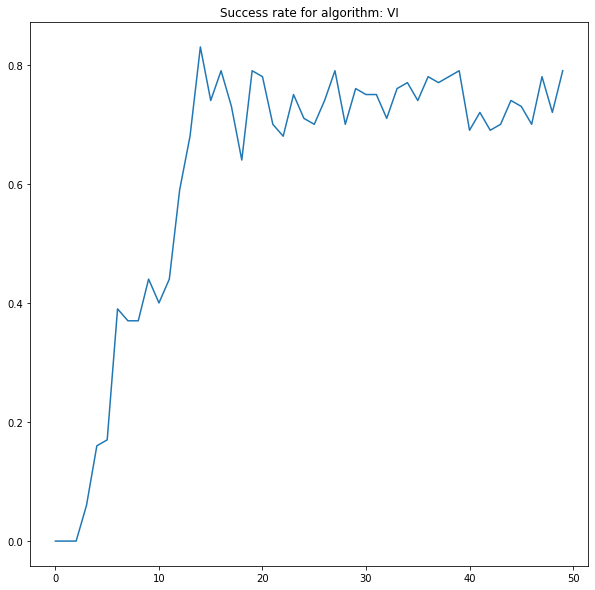

In [5]:
'''
Q1.5 Value Iterations algo;
'''
def value_iteration(env, S, A, P, R, gamma, maxIter, t, n):
    '''
    :param env: the environment
    :param S: the state space; 
    :param A: the action space;
    :param P: the transition probabilities;
    :param R: the reward functions;
    :param gamma: the discount factor;
    :param maxIter: the maximum number of iterations to perform;
    :param t: the threshold of exiting value evaluation.
    :param n: number of times to perform value eval and improvement;
    '''
    delta = np.inf
    V = np.zeros(S.shape)
    V_next = np.zeros(S.shape)
    pi = np.zeros(S.shape, dtype=int)
    i = 0
    m = np.zeros(n)
    while i < n:
    # while i < maxIter and np.amax(delta)> t:
        for s in range(S.shape[0]):
            for a in range(A.shape[0]):
                p = P[s, a, :]
                ind = np.nonzero(p)
                r = R[s, a, ind]
                q = np.dot(p[ind], (r + gamma * V[ind]).flatten())
                if q > V_next[s]:
                    V_next[s] = q
                    pi[s] = a
        delta = np.absolute(V_next - V)
        V = np.copy(V_next)
        V_next = np.zeros(S.shape)
        # plot_optimal_value_and_control(V.reshape(4,4,order='C'), pi.reshape(4,4,order='C'), i, "Value Iteration", gamma)
        m[i] = testPolicy(env, pi, 100)
        i += 1
    return m, V, pi
        
def value_iteration_main():
    gamma = 0.95
    n = 50
    maxIter = 20
    t = 1e-6
    S = np.arange(0, 16)
    A = np.arange(0, 4)
    env = gym.make("FrozenLake-v0", is_slippery=True)
    P, R = learn_model_frozen_lake(env)
    m, V, pi = value_iteration(env, S, A, P, R, gamma, maxIter, None, n)
    plot_optimal_value_and_control(V.reshape(4,4,order='C'), pi.reshape(4,4,order='C'), \
                                   n, "Value Iteration", gamma, 'P1_VI_Value', True)
    env.close()
    plot_success(m, "VI", 'P1_VI_success', True)

value_iteration_main()   

In [6]:
'''
Q2.1 Q-learning
'''
def linear_epsilon_array(t, n, l=None):
    return 1 - t.astype(float)/n

def linear_epsilon(t, n, l=None):
    return 1 - float(t)/n

def test_linear_epsilon():
    episodes = np.arange(0, 5000, 100)
    print(linear_epsilon_array(episodes, 5000))
    
def q_learning(env, S, A, alpha, gamma, n_eps, eps_func, l=None):
    '''
    :param env: the environment to explore;
    :param S: the state space;
    :param A: the action space;
    :param alpha: the learning rate;
    :param epsilon: epsilon for choosing action;
    :param n_eps: number of episodes;
    :param eps_func: a function for calculating epsilon value
    :param l: a hyperparameter for decay;
    '''
    q = np.zeros((S.shape[0], A.shape[0]))
    pi = np.zeros(S.shape, dtype=int)
    success = np.zeros(int(n_eps / 100))
    for i in range(n_eps):
        s = env.reset()
        done = False 
        epsilon = eps_func(i, n_eps, l)
        pa = 1 - epsilon + epsilon / A.shape[0] # p for argmax
        pr = epsilon / A.shape[0] * np.ones(A.shape[0]) # p for the rest

        while not done:
            p1 = np.copy(pr)
            p1[np.argmax(q[s, :])] = pa
            a = np.random.choice(a=A,p=p1)
            s_next, reward, done, info = env.step(a) # S, A, S'
            a_next = np.argmax(q[s_next, :])
            # print(alpha, q[s_next, a_next], reward, gamma, q[s,a])
            q[s, a] = q[s, a] + alpha * (reward + gamma * q[s_next, a_next] - q[s, a])
            s = s_next
            a = a_next
        if i % 100 == 0:
            pi = np.argmax(q, axis = 1)
            success[int(i / 100)] = testPolicy(env, pi, 100)
            # plot_optimal_value_and_control(V.reshape(4,4,order='C'), pi.reshape(4,4,order='C'), i, "Q-Learning", gamma)
    pi = np.argmax(q, axis = 1)
    V = np.max(q, axis=1)
    return success, pi, V

test_linear_epsilon()

[1.   0.98 0.96 0.94 0.92 0.9  0.88 0.86 0.84 0.82 0.8  0.78 0.76 0.74
 0.72 0.7  0.68 0.66 0.64 0.62 0.6  0.58 0.56 0.54 0.52 0.5  0.48 0.46
 0.44 0.42 0.4  0.38 0.36 0.34 0.32 0.3  0.28 0.26 0.24 0.22 0.2  0.18
 0.16 0.14 0.12 0.1  0.08 0.06 0.04 0.02]


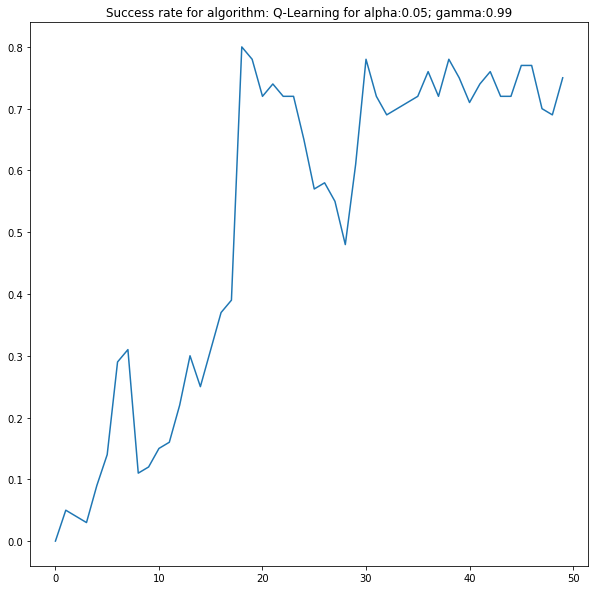

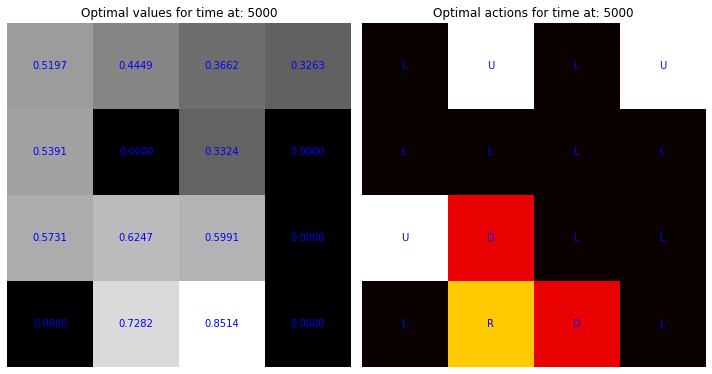

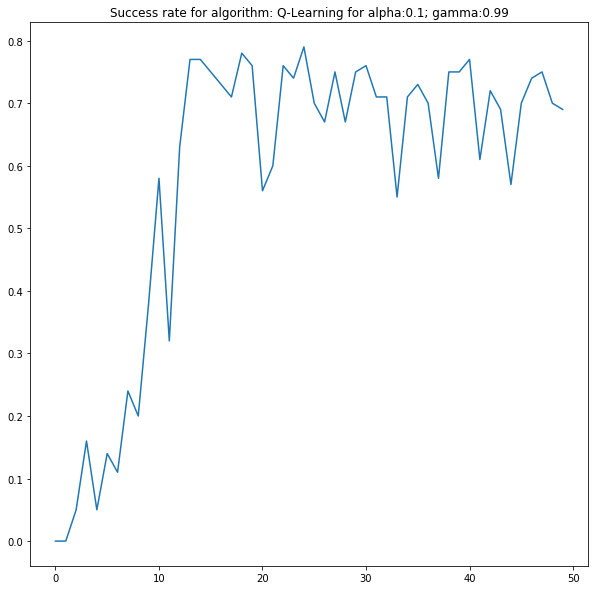

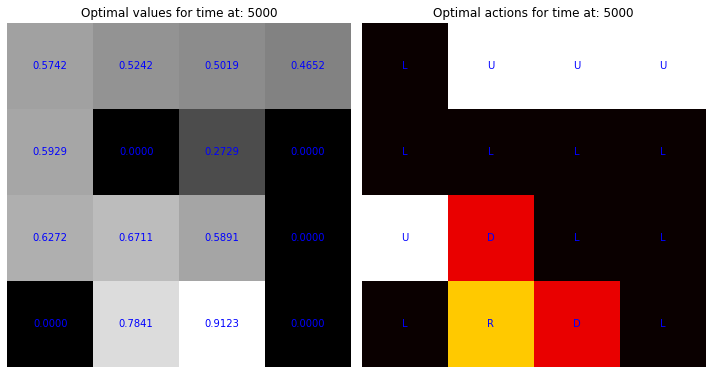

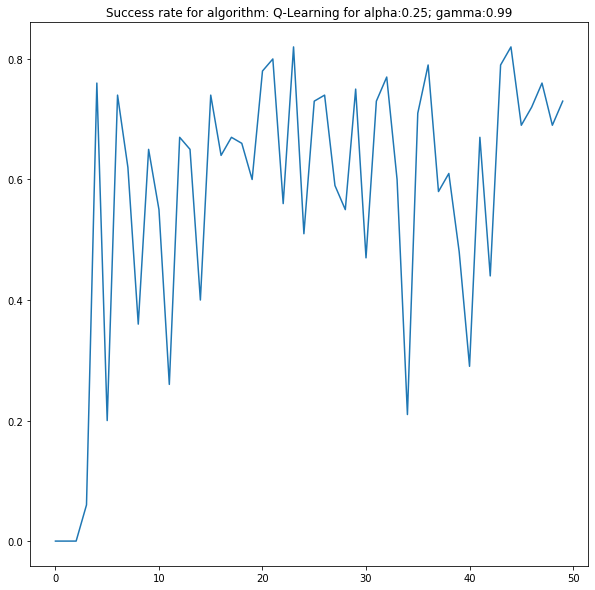

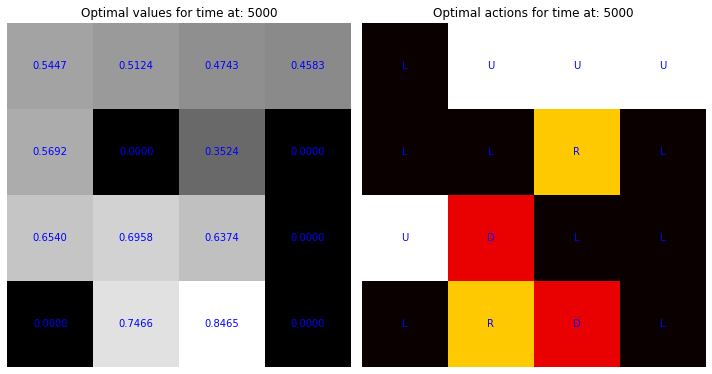

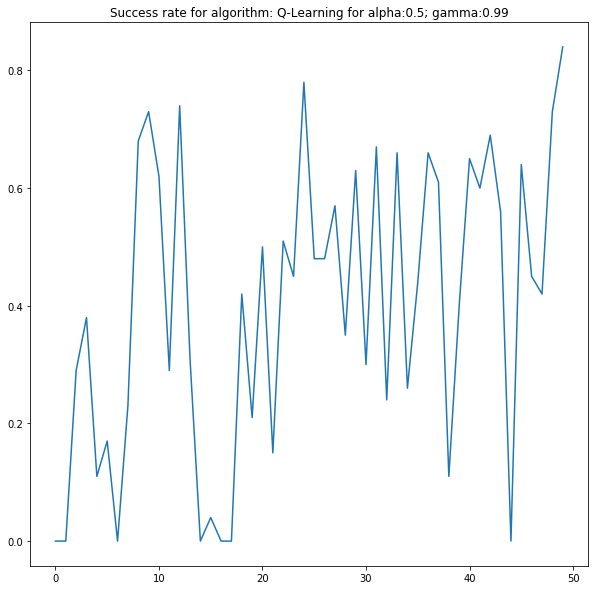

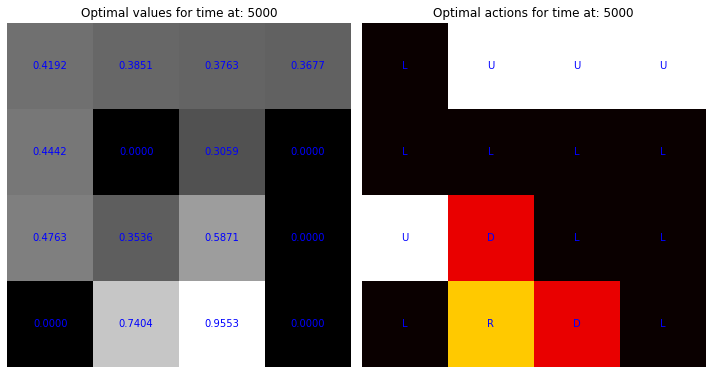

In [9]:
'''
Q2.1 a)
'''
def q_learning_main_a():
    gamma = 0.99
    episodes = 5000
    S = np.arange(0, 16)
    A = np.arange(0, 4)
    env = gym.make("FrozenLake-v0", is_slippery=True)
    l = [0.05, 0.1, 0.25, 0.5]
    for alpha in l:
        m, pi, V = q_learning(env, S, A, alpha, gamma, episodes, linear_epsilon)
        env.close()
        plot_success(m, "Q-Learning for alpha:%s; gamma:%s" % (alpha, gamma), \
                    "P2a)_alpha%s_success"%alpha, True)
        plot_optimal_value_and_control(V.reshape(4,4,order='C'), pi.reshape(4,4,order='C'),\
                                       episodes, "Q-Learning", gamma)

q_learning_main_a()

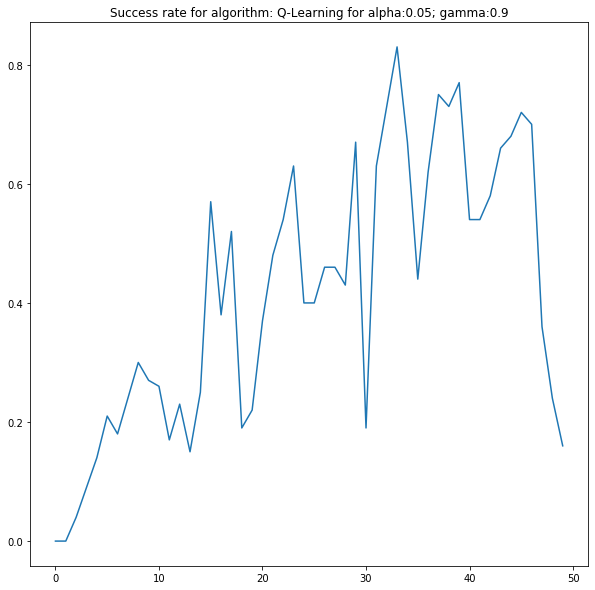

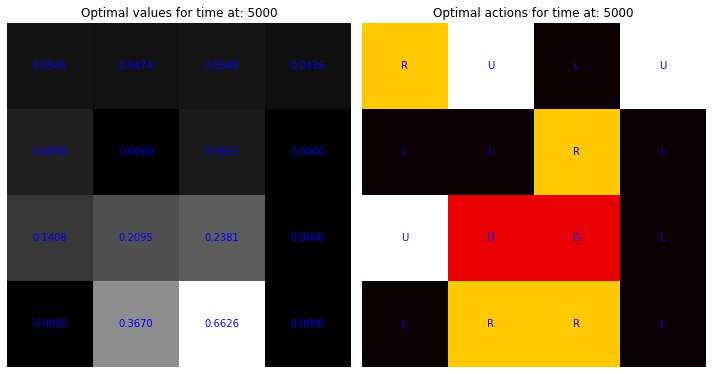

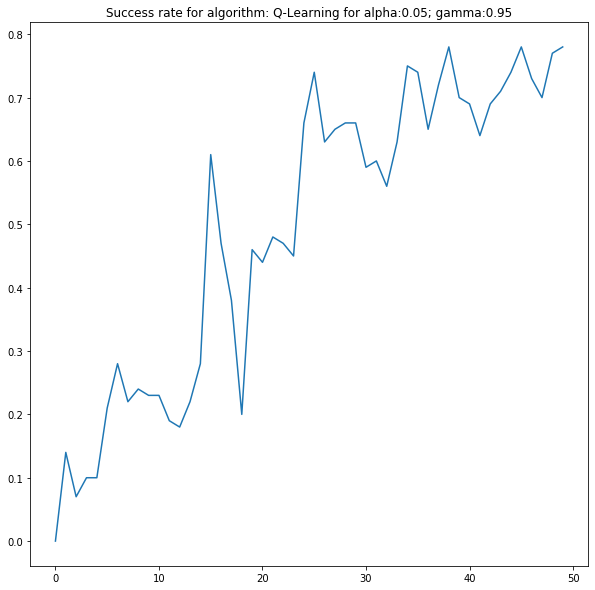

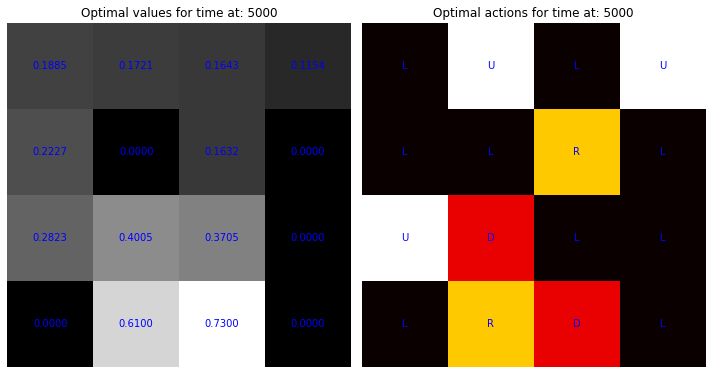

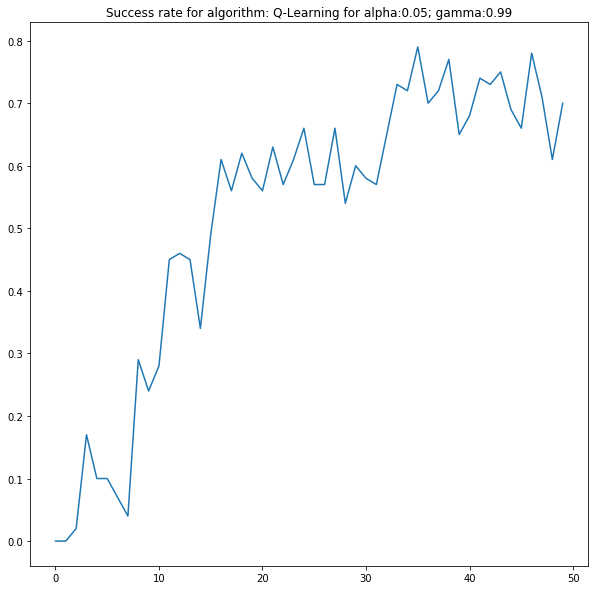

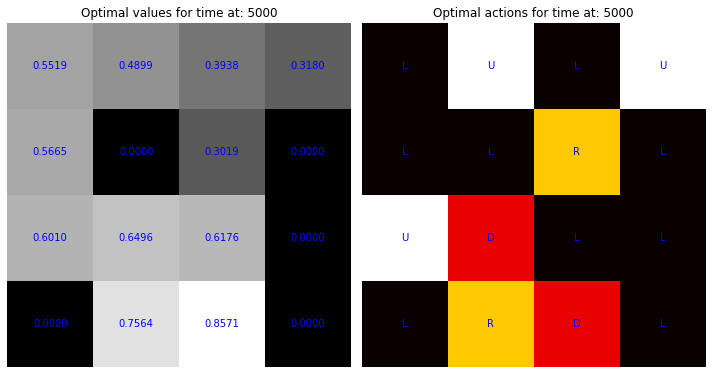

In [12]:
'''
Q2.1 b)
'''
def q_learning_main_b():
    l = [0.9, 0.95, 0.99]
    episodes = 5000
    S = np.arange(0, 16)
    A = np.arange(0, 4)
    env = gym.make("FrozenLake-v0", is_slippery=True)
    alpha = 0.05
    for gamma in l:
        m, pi, V = q_learning(env, S, A, alpha, gamma, episodes, linear_epsilon)
        env.close()
        plot_success(m, "Q-Learning for alpha:%s; gamma:%s" % (alpha, gamma),\
                    "P2b)_gamma%s_success"%gamma, True)
        plot_optimal_value_and_control(V.reshape(4,4,order='C'), pi.reshape(4,4,order='C'), \
                    episodes, "Q-Learning", gamma)

q_learning_main_b()

In [14]:
'''
Q2.2
'''
def exponential_epsilon(t, n, l):
    return np.exp(-l * t / n)

def inverse_epsilon(t, n, l):
    return 1.0 / (t + 1)

def test_exponential_epsilon():
    ls = np.arange(0, 5000, 100)
    print(exponential_epsilon(ls,5000,4))
    
test_exponential_epsilon()

[1.         0.92311635 0.85214379 0.78662786 0.72614904 0.67032005
 0.61878339 0.57120906 0.52729242 0.48675226 0.44932896 0.41478291
 0.38289289 0.35345468 0.32627979 0.30119421 0.2780373  0.25666078
 0.23692776 0.21871189 0.20189652 0.18637398 0.17204486 0.15881743
 0.14660696 0.13533528 0.12493021 0.11532512 0.1064585  0.09827359
 0.09071795 0.08374323 0.07730474 0.07136127 0.06587475 0.06081006
 0.05613476 0.05181892 0.04783489 0.04415717 0.0407622  0.03762826
 0.03473526 0.03206469 0.02959944 0.02732372 0.02522297 0.02328374
 0.0214936  0.01984109]


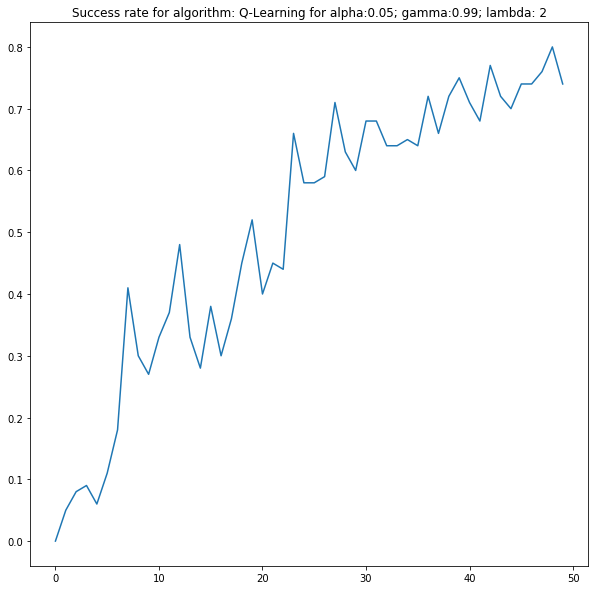

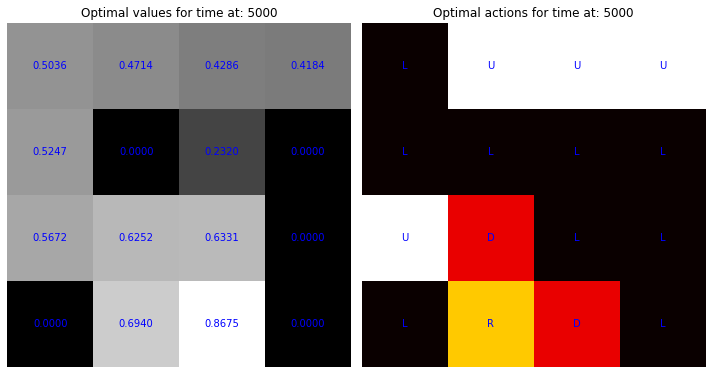

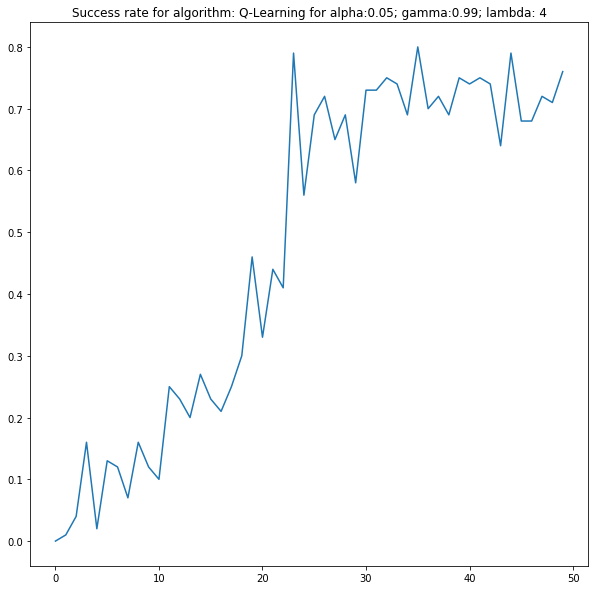

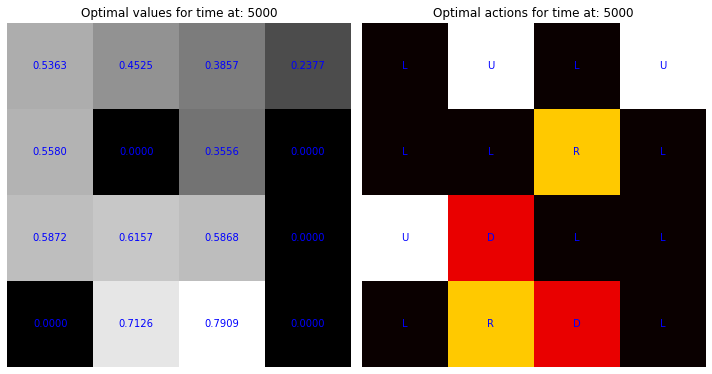

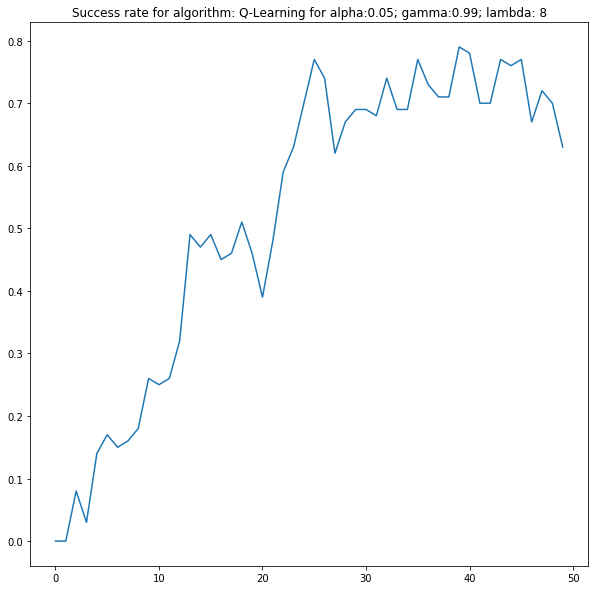

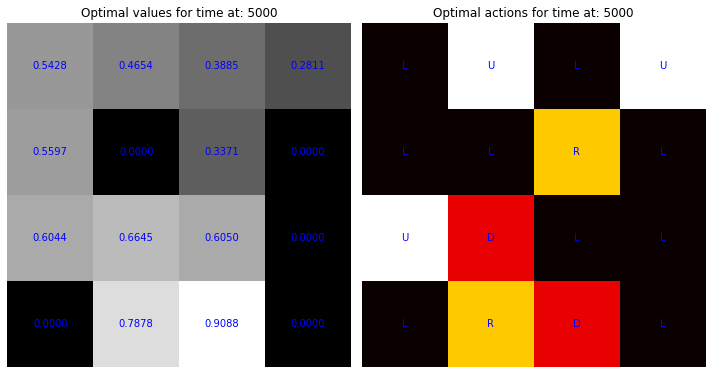

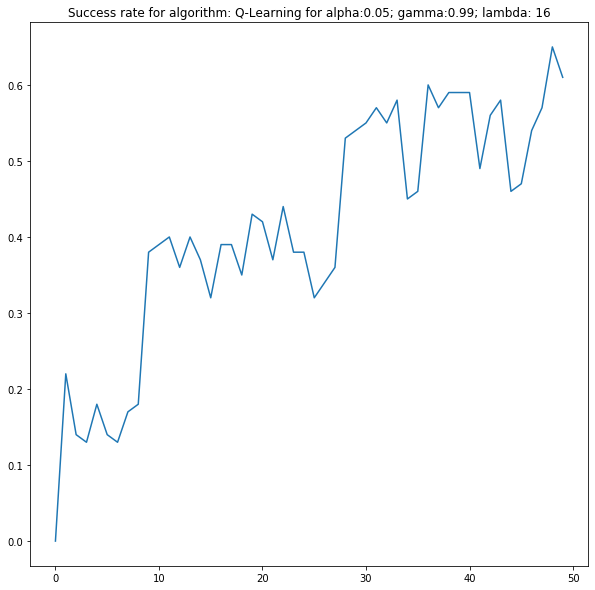

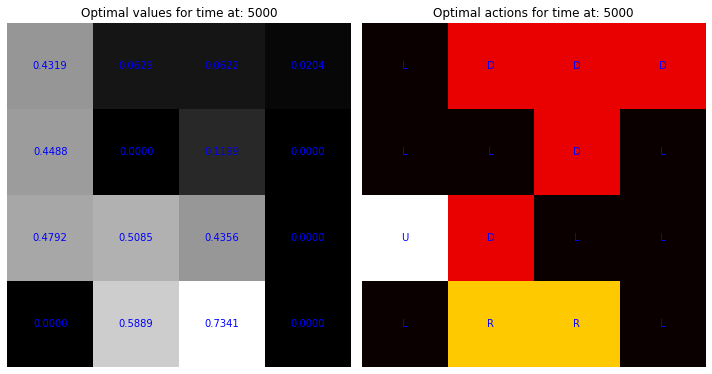

In [22]:
def q_learning_main_exponential():
    ls = [2, 4, 8, 16]
    episodes = 5000
    S = np.arange(0, 16)
    A = np.arange(0, 4)
    env = gym.make("FrozenLake-v0", is_slippery=True)
    alpha = 0.05
    gamma = 0.99
    for l in ls:
        m, pi, V = q_learning(env, S, A, alpha, gamma, episodes, exponential_epsilon, l)
        env.close()
        plot_success(m, "Q-Learning for alpha:%s; gamma:%s; lambda: %s" % (alpha, gamma, l),\
                     "P2_exponential_success_l%s"%l, True)
        plot_optimal_value_and_control(V.reshape(4,4,order='C'), pi.reshape(4,4,order='C'),\
                                       episodes, "Q-Learning", gamma, \
                                      "P2_exponential_value%s"%l, True)

q_learning_main_exponential()

In [ ]:
def q_learning_main_inverse():
    episodes = 5000
    S = np.arange(0, 16)
    A = np.arange(0, 4)
    env = gym.make("FrozenLake-v0", is_slippery=True)
    alpha = 0.05
    gamma = 0.95
    m, pi, V = q_learning(env, S, A, alpha, gamma, episodes, inverse_epsilon)
    env.close()
    plot_success(m, "Q-Learning for alpha:%s; gamma:%s; eps = 1/k" % (alpha, gamma))
    plot_optimal_value_and_control(V.reshape(4,4,order='C'), pi.reshape(4,4,order='C'), episodes, "Q-Learning", gamma)

q_learning_main_inverse()